

# Recurrent Neural Network (RNN)


<br>


In [6]:
import numpy as np
import pandas as pd
import warnings
import yfinance as yf
import ta
warnings.filterwarnings("ignore")

In [7]:
import matplotlib.pyplot as plt

import matplotlib as mpl
from matplotlib import cycler
colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")

# Features engineering

### dummy variable

https://fa.wikipedia.org/wiki/%D9%85%D8%AA%D8%BA%DB%8C%D8%B1_%D8%A2%D8%B2%D8%A7%D8%AF_%D9%88_%D9%85%D8%AA%D8%BA%DB%8C%D8%B1_%D9%85%D9%82%DB%8C%D8%AF

In [8]:
def feature_engineering(symbol , forex = False):
    

    df = yf.download(symbol).dropna()
    df.columns = ["open", "high", "low", "close", "adj close", "volume"]
    df.index.name = "time"
    
    if forex:
        del df["adj close"]
        

    
    # ما دیتافریم را کپی می کنیم تا از تداخل در داده ها جلوگیری کنیم
    df_copy = df.copy()
    
    # ایجاد بازده ها
    df_copy["returns"] = df_copy["close"].pct_change(1)
    df_copy["dummy"] = np.round(df_copy["returns"]+0.5)

    # ایجاد میانگین های متحرک
    df_copy["SMA 15"] = df_copy[["close"]].rolling(15).mean().shift(1)
    df_copy["SMA 60"] = df_copy[["close"]].rolling(60).mean().shift(1)
    
    # ایجاد نوسانات
    df_copy["MSD 10"] = df_copy[["returns"]].rolling(10).std().shift(1)
    df_copy["MSD 30"] = df_copy[["returns"]].rolling(30).std().shift(1)
    
    # ایجاد RSI
    RSI = ta.momentum.RSIIndicator(df_copy["close"], window= 14, fillna = False)
    df_copy["rsi"] = RSI.rsi().shift()
    
    return df_copy.dropna()



In [9]:
dfc = feature_engineering("BTC-USD")
dfc

[*********************100%%**********************]  1 of 1 completed


,open,high,low,close,adj close,volume,returns,dummy,SMA 15,SMA 60,MSD 10,MSD 30,rsi
time,,,,,,,,,,,,,
2014-11-16,374.730011,390.799011,374.601990,387.881989,387.881989,11905600,0.031236,1.0,360.166400,373.194417,0.059374,0.040284,52.526052
2014-11-17,388.348999,410.199005,377.502014,387.407990,387.407990,41518800,-0.001222,0.0,364.308600,372.036884,0.059454,0.040680,55.885665
2014-11-18,387.785004,392.402008,371.117004,375.197998,375.197998,32222500,-0.031517,0.0,368.409666,371.419683,0.058641,0.040524,55.714363
2014-11-19,373.895996,386.480988,373.895996,380.554993,380.554993,18931800,0.014278,1.0,371.585933,371.093050,0.060390,0.040934,51.348107
2014-11-20,380.307007,382.024994,356.781006,357.839996,357.839996,25233200,-0.059689,0.0,374.923466,370.620567,0.058663,0.040894,53.085274
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-11,27392.076172,27474.115234,26561.099609,26873.320312,26873.320312,13648094333,-0.018900,0.0,27363.746354,26785.106641,0.017066,0.014316,53.114576
2023-10-12,26873.292969,26921.439453,26558.320312,26756.798828,26756.798828,9392909295,-0.004336,0.0,27407.484375,26742.729232,0.012608,0.013894,46.370587
2023-10-13,26752.878906,27092.697266,26686.322266,26862.375000,26862.375000,15165312851,0.003946,1.0,27434.423177,26700.627311,0.011867,0.013153,44.986082


In [10]:
dfc.dummy.value_counts()

dummy
1.0    1723
0.0    1533
Name: count, dtype: int64

In [11]:
dfc.columns

Index(['open', 'high', 'low', 'close', 'adj close', 'volume', 'returns',
       'dummy', 'SMA 15', 'SMA 60', 'MSD 10', 'MSD 30', 'rsi'],
      dtype='object')

In [12]:
split = int(0.85*len(dfc))


X_train = dfc[["SMA 15", "SMA 60", "MSD 10", "MSD 30", "rsi"]].iloc[:split,:]
y_train = dfc[["dummy"]].iloc[:split,:]


X_test = dfc[["SMA 15", "SMA 60", "MSD 10", "MSD 30", "rsi"]].iloc[split:,:]
y_test = dfc[["dummy"]].iloc[split:,:]

In [13]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [14]:
X_train_sc

array([[-0.73197442, -0.72568396,  1.33162741,  0.31571675, -0.07789141],
       [-0.73172571, -0.72575441,  1.33574904,  0.34078789,  0.15991246],
       [-0.73147946, -0.72579197,  1.29379762,  0.33092354,  0.14778716],
       ...,
       [ 1.05594529,  1.32436794, -0.10749892, -0.12546812, -0.85231871],
       [ 1.05487745,  1.3124319 , -0.38848297, -0.10535602, -1.04625883],
       [ 1.04666241,  1.29782012, -0.25007955, -0.01192863, -1.41904755]])

In [15]:
X_test_sc

array([[ 1.01880767,  1.2801204 ,  1.10062097,  0.60729302, -2.0866454 ],
       [ 0.98070127,  1.26150918,  1.06044145,  0.54714882, -2.11991759],
       [ 0.94379627,  1.24340012,  1.11398363,  0.53019952, -1.97610545],
       ...,
       [ 0.89367554,  0.87673982, -1.11815278, -1.4040971 , -0.61159392],
       [ 0.89303838,  0.87415704, -1.10887161, -1.42037865, -0.50135705],
       [ 0.89283818,  0.87181511, -1.17258569, -1.43102295, -0.50199238]])

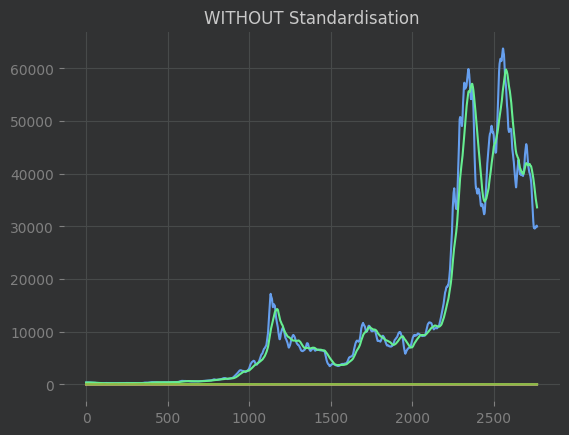

In [16]:
plt.plot(X_train.values)
plt.title("WITHOUT Standardisation")
plt.show()

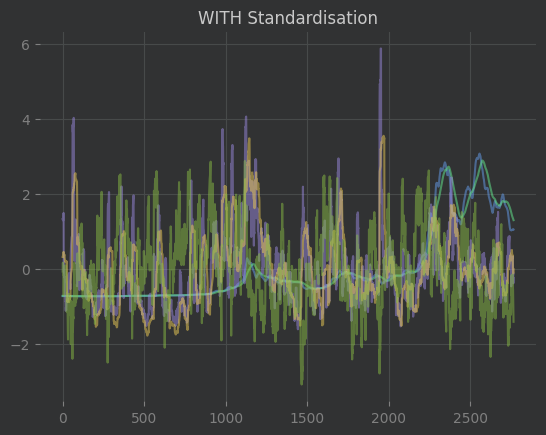

In [17]:
plt.plot(X_train_sc, alpha=0.5)
plt.title("WITH Standardisation")
plt.show()

# داده های 2 بعدی را به داده های 3 بعدی تبدیل می کنیم

In [18]:
def X_3d_RNN(X_s, y_s, lag):

    # Simple verification
    if len(X_s) != len(y_s):
        print("Warnings")

    # Create the X_train
    X_train = []
    for variable in range(0, X_s.shape[1]):
        X = []
        for i in range(lag, X_s.shape[0]):
            X.append(X_s[i-lag:i, variable])
        X_train.append(X)
    X_train, np.array(X_train)
    X_train = np.swapaxes(np.swapaxes(X_train, 0, 1), 1, 2)

    # Create the y_train
    y_train = []
    for i in range(lag, y_s.shape[0]):
        y_train.append(y_s[i, :].reshape(-1,1).transpose())
    y_train = np.concatenate(y_train, axis=0)
    return X_train, y_train



In [19]:
X_train_3d, y_train_3d = X_3d_RNN(X_train_sc, y_train.values, lag = 20)
X_test_3d, y_test_3d = X_3d_RNN(X_test_sc, y_test.values, lag  = 20)

In [20]:
pd.DataFrame(X_train_3d[0])

,0,1,2,3,4
0,-0.731974,-0.725684,1.331627,0.315717,-0.077891
1,-0.731726,-0.725754,1.335749,0.340788,0.159912
2,-0.731479,-0.725792,1.293798,0.330924,0.147787
3,-0.731289,-0.725812,1.383989,0.356915,-0.161270
4,-0.731088,-0.725841,1.294957,0.354360,-0.038308
5,-0.731015,-0.725882,1.476496,0.443529,-0.565081
6,-0.731009,-0.725934,1.489995,0.450402,-0.708555
7,-0.730967,-0.726018,-0.096524,0.345112,-0.652783
8,-0.730878,-0.726075,0.166707,0.388838,-0.274255
9,-0.730824,-0.726110,0.093955,0.372902,-0.054222


In [21]:
np.shape(X_train_3d)

(2747, 20, 5)

In [22]:
y_train_3d[0]

array([0.])

In [23]:
y_train_3d

array([[0.],
       [1.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

# RNN

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

nb_hidden_layer = 3


classifier = Sequential()

classifier.add(LSTM(units = 10, return_sequences = True,
                    input_shape = (X_train_3d.shape[1],X_train_3d.shape[2],)))



for _ in range(1):
    classifier.add(LSTM(units = 10, return_sequences = True))
    classifier.add(Dropout(0.15))

# LAST LSTM LAYER BUT WITH return_sequences = False 
classifier.add(LSTM(units = 10, return_sequences = False))


# OUTPUT DENSE LAYER
classifier.add(Dense(1, activation="sigmoid"))


classifier.compile(loss="binary_crossentropy", optimizer="adam")


early_stop = EarlyStopping(verbose=1, patience = 5)

classifier.fit(X_train_3d, y_train_3d, validation_data=(X_test_3d, y_test_3d), epochs=100, callbacks=[early_stop])

Epoch 1/100
86/86 [==============================] - 6s 19ms/step - loss: 0.6900 - val_loss: 0.6970
Epoch 2/100
86/86 [==============================] - 1s 10ms/step - loss: 0.6880 - val_loss: 0.6995
Epoch 3/100
86/86 [==============================] - 1s 9ms/step - loss: 0.6874 - val_loss: 0.6994
Epoch 4/100
86/86 [==============================] - 1s 10ms/step - loss: 0.6870 - val_loss: 0.6988
Epoch 5/100
86/86 [==============================] - 1s 10ms/step - loss: 0.6868 - val_loss: 0.7019
Epoch 6/100
86/86 [==============================] - 1s 10ms/step - loss: 0.6859 - val_loss: 0.6991
Epoch 6: early stopping


<Axes: >

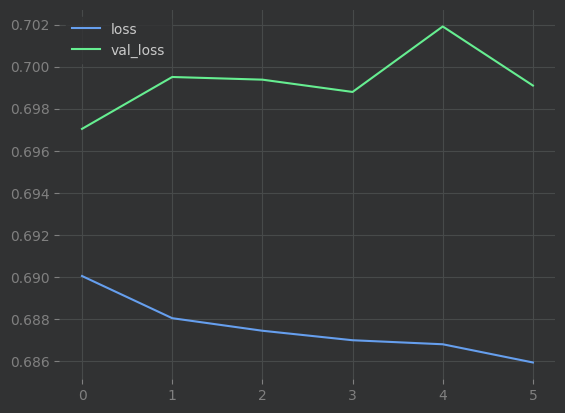

In [25]:
pd.DataFrame(classifier.history.history).plot()

In [26]:
np.shape(X_train_3d)

(2747, 20, 5)

In [27]:
np.shape(X_test_3d)

(469, 20, 5)

In [28]:
2747 + 469

3216

In [29]:
np.shape(dfc)

(3256, 13)

In [31]:
lag = 20

In [32]:
# ایجاد پیش بینی برای کل مجموعه داده
y_pred_train = np.concatenate((np.zeros([lag,1]),classifier.predict(X_train_3d)),
                                    axis=0)

y_pred_test = np.concatenate((np.zeros([lag,1]),classifier.predict(X_test_3d)),
                                    axis=0)


dfc["prediction"] = np.concatenate((y_pred_train,y_pred_test),
                                    axis=0)

dfc["prediction"] = np.where(dfc["prediction"] < 0.5, -1,1)

# محاسبه استراتژی
dfc["strategy"] =  dfc["prediction"].shift(1) * dfc["returns"]

15/15 [==============================] - 0s 2ms/step


In [33]:
np.shape(y_pred_train)

(2767, 1)

In [34]:
np.shape(y_pred_test)

(489, 1)

In [35]:
2767 + 489

3256

In [36]:
np.shape(dfc)

(3256, 15)

<Axes: xlabel='time'>

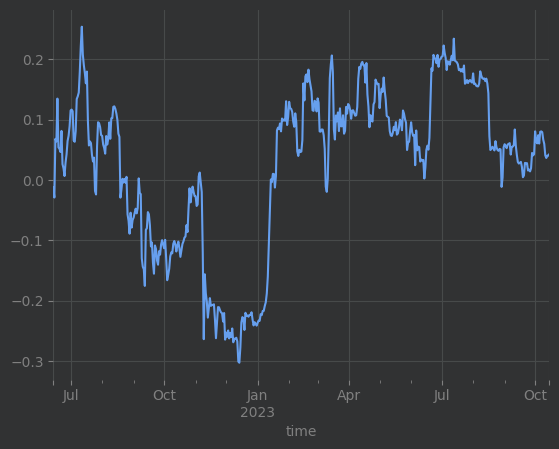

In [37]:
dfc["strategy"].iloc[split:].cumsum().plot()

# Automatization

In [38]:
def feature_engineering(symbol , forex = False):
    

    df = yf.download(symbol).dropna()
    df.columns = ["open", "high", "low", "close", "adj close", "volume"]
    df.index.name = "time"
    
    if forex:
        del df["adj close"]
        

    
    # ما دیتافریم را کپی می کنیم تا از تداخل در داده ها جلوگیری کنیم
    df_copy = df.copy()
    
    # ایجاد بازده ها
    df_copy["returns"] = df_copy["close"].pct_change(1)
    df_copy["dummy"] = np.round(df_copy["returns"]+0.5)

    # ایجاد میانگین های متحرک
    df_copy["SMA 15"] = df_copy[["close"]].rolling(15).mean().shift(1)
    df_copy["SMA 60"] = df_copy[["close"]].rolling(60).mean().shift(1)
    
    # ایجاد نوسانات
    df_copy["MSD 10"] = df_copy[["returns"]].rolling(10).std().shift(1)
    df_copy["MSD 30"] = df_copy[["returns"]].rolling(30).std().shift(1)
    
    # ایجاد RSI
    RSI = ta.momentum.RSIIndicator(df_copy["close"], window= 14, fillna = False)
    df_copy["rsi"] = RSI.rsi().shift()
    
    return df_copy.dropna()




def X_3d_RNN(X_s, y_s, lag):

    if len(X_s) != len(y_s):
        print("Warnings")

    X_train = []
    for variable in range(0, X_s.shape[1]):
        X = []
        for i in range(lag, X_s.shape[0]):
            X.append(X_s[i-lag:i, variable])
        X_train.append(X)
    X_train, np.array(X_train)
    X_train = np.swapaxes(np.swapaxes(X_train, 0, 1), 1, 2)

    # Create the y_train
    y_train = []
    for i in range(lag, y_s.shape[0]):
        y_train.append(y_s[i, :].reshape(-1,1).transpose())
    y_train = np.concatenate(y_train, axis=0)
    return X_train, y_train


import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def RNN(symbol, nb_neurons=10, nb_hidden_layer=1, lag=15, nb_model=None):
    
  
    dfc = feature_engineering(symbol)


    split = int(0.80*len(dfc))
    split_val = int(0.90*len(dfc))
 
    X_train = dfc[['SMA 15', 'SMA 60',
        'MSD 10', 'MSD 30', 'rsi']].iloc[:split,:]
    y_train = dfc[["dummy"]].iloc[:split]


    X_test = dfc[['SMA 15', 'SMA 60',
        'MSD 10', 'MSD 30', 'rsi']].iloc[split:,:]
    y_test = dfc[["dummy"]].iloc[split:]

    from sklearn.preprocessing import StandardScaler

    sc = StandardScaler()

    X_train_sc = sc.fit_transform(X_train)
    X_test_sc = sc.transform(X_test)

    X_train_3d, y_train_3d = X_3d_RNN(X_train_sc, y_train.values, lag)
    X_test_3d, y_test_3d = X_3d_RNN(X_test_sc, y_test.values, lag)

    classifier = Sequential()

    classifier.add(LSTM(units = nb_neurons, return_sequences = True,
                      input_shape = (X_train_3d.shape[1],X_train_3d.shape[2],)))


    for _ in range(nb_hidden_layer):
        
        classifier.add(LSTM(units = nb_neurons, return_sequences = True))
        classifier.add(Dropout(0.20))

    classifier.add(LSTM(units = nb_neurons, return_sequences = False))


    classifier.add(Dense(1, activation="sigmoid"))

    classifier.compile(loss="binary_crossentropy", optimizer="adam")


    early_stop = EarlyStopping(verbose=1, patience = 5)
    classifier.fit(X_train_3d, y_train_3d, validation_data=(X_test_3d, y_test_3d),
                 epochs=1, callbacks=[early_stop])
  
  # ایجاد پیش بینی
    y_pred_train = np.concatenate((np.zeros([lag,1]),classifier.predict(X_train_3d)),
                                      axis=0)

    y_pred_test = np.concatenate((np.zeros([lag,1]),classifier.predict(X_test_3d)),
                                      axis=0)

    dfc["prediction"] = np.concatenate((y_pred_train,y_pred_test),
                                      axis=0)

    dfc["prediction"] = np.where(dfc["prediction"] < 0.5, -1,1)

  # محاسبه استراتژی
    dfc["strategy"] = np.sign(dfc["prediction"]) * dfc["returns"]

    if nb_model!=None:
        
        classifier.save_weights(f"Weights_RNN/RNN n°{nb_model}")
        return dfc["strategy"].iloc[split+lag:split_val], dfc["strategy"].iloc[split_val:]

    else:
        return dfc["strategy"].iloc[split+lag:split_val], dfc["strategy"].iloc[split_val:]

In [39]:
sr = RNN("BTC-USD", nb_model=15)

sr

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


(time
 2022-01-17   -0.020024
 2022-01-18    0.002960
 2022-01-19   -0.014898
 2022-01-20    0.025486
 2022-01-21    0.103812
                 ...   
 2022-11-19    0.000825
 2022-11-20   -0.025115
 2022-11-21   -0.030969
 2022-11-22    0.025494
 2022-11-23    0.026000
 Name: strategy, Length: 311, dtype: float64,
 time
 2022-11-24   -0.000376
 2022-11-25   -0.004976
 2022-11-26   -0.003484
 2022-11-27   -0.001194
 2022-11-28   -0.013822
                 ...   
 2023-10-11   -0.018900
 2023-10-12   -0.004336
 2023-10-13    0.003946
 2023-10-14   -0.000025
 2023-10-15    0.003613
 Name: strategy, Length: 326, dtype: float64)

In [40]:
from tqdm import tqdm

returns_test = []
returns_val = []


# بازده را در طول دوره های آزمایش و اعتبارسنجی محاسبه می کنیم
for i in tqdm(range(40)):
    
    test, val = RNN("BTC-USD", nb_model=i)
    returns_test.append(test)
    returns_val.append(val)

  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


  2%|██                                                                                 | 1/40 [00:11<07:28, 11.51s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


  5%|████▏                                                                              | 2/40 [00:23<07:28, 11.79s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


  8%|██████▏                                                                            | 3/40 [00:35<07:23, 11.98s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


 10%|████████▎                                                                          | 4/40 [00:47<07:02, 11.73s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


 12%|██████████▍                                                                        | 5/40 [00:58<06:45, 11.58s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


 15%|████████████▍                                                                      | 6/40 [01:09<06:27, 11.39s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


 18%|██████████████▌                                                                    | 7/40 [01:18<05:51, 10.64s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


 20%|████████████████▌                                                                  | 8/40 [01:27<05:25, 10.17s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


 22%|██████████████████▋                                                                | 9/40 [01:37<05:09,  9.99s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


 25%|████████████████████▌                                                             | 10/40 [01:46<04:57,  9.90s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


 28%|██████████████████████▌                                                           | 11/40 [01:56<04:46,  9.87s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


 30%|████████████████████████▌                                                         | 12/40 [02:06<04:37,  9.91s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


 32%|██████████████████████████▋                                                       | 13/40 [02:19<04:50, 10.76s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


 35%|████████████████████████████▋                                                     | 14/40 [02:31<04:50, 11.19s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


 38%|██████████████████████████████▊                                                   | 15/40 [02:42<04:36, 11.08s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


 40%|████████████████████████████████▊                                                 | 16/40 [02:53<04:25, 11.06s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


 42%|██████████████████████████████████▊                                               | 17/40 [03:04<04:12, 10.96s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


 45%|████████████████████████████████████▉                                             | 18/40 [03:13<03:47, 10.35s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


 48%|██████████████████████████████████████▉                                           | 19/40 [03:22<03:33, 10.18s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████                                         | 20/40 [03:33<03:23, 10.15s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


 52%|███████████████████████████████████████████                                       | 21/40 [03:43<03:13, 10.19s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


 55%|█████████████████████████████████████████████                                     | 22/40 [03:52<02:55,  9.78s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


 57%|███████████████████████████████████████████████▏                                  | 23/40 [04:02<02:47,  9.85s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


 60%|█████████████████████████████████████████████████▏                                | 24/40 [04:13<02:44, 10.30s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


 62%|███████████████████████████████████████████████████▎                              | 25/40 [04:24<02:37, 10.50s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [04:36<02:34, 11.03s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [04:47<02:22, 10.98s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [04:58<02:10, 10.84s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [05:07<01:56, 10.56s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [05:18<01:45, 10.57s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [05:27<01:31, 10.21s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [05:37<01:20, 10.06s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [05:49<01:14, 10.63s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [06:01<01:06, 11.05s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [06:13<00:56, 11.35s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [06:23<00:42, 10.75s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [06:32<00:30, 10.24s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [06:41<00:19,  9.91s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [06:50<00:09,  9.82s/it]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20/20 [==============================] - 0s 2ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [07:00<00:00, 10.50s/it]


In [41]:
RNN_returns = pd.DataFrame(returns_test, index=[f"RNN n°{i}" for i in range(len(returns_test))]).transpose()
RNN_returns

,RNN n°0,RNN n°1,RNN n°2,RNN n°3,RNN n°4,RNN n°5,RNN n°6,RNN n°7,RNN n°8,RNN n°9,...,RNN n°30,RNN n°31,RNN n°32,RNN n°33,RNN n°34,RNN n°35,RNN n°36,RNN n°37,RNN n°38,RNN n°39
time,,,,,,,,,,,,,,,,,,,,,
2022-01-17,-0.020024,-0.020024,-0.020024,-0.020024,0.020024,-0.020024,0.020024,0.020024,-0.020024,0.020024,...,0.020024,-0.020024,-0.020024,-0.020024,-0.020024,-0.020024,-0.020024,-0.020024,-0.020024,0.020024
2022-01-18,0.002960,0.002960,0.002960,0.002960,-0.002960,0.002960,-0.002960,-0.002960,0.002960,-0.002960,...,-0.002960,0.002960,0.002960,0.002960,0.002960,0.002960,0.002960,0.002960,0.002960,-0.002960
2022-01-19,-0.014898,-0.014898,-0.014898,-0.014898,0.014898,-0.014898,0.014898,0.014898,-0.014898,0.014898,...,0.014898,-0.014898,0.014898,-0.014898,-0.014898,-0.014898,-0.014898,-0.014898,-0.014898,0.014898
2022-01-20,-0.025486,-0.025486,-0.025486,-0.025486,0.025486,-0.025486,0.025486,0.025486,-0.025486,0.025486,...,0.025486,-0.025486,0.025486,-0.025486,0.025486,-0.025486,-0.025486,-0.025486,-0.025486,0.025486
2022-01-21,-0.103812,-0.103812,-0.103812,-0.103812,0.103812,-0.103812,0.103812,0.103812,-0.103812,0.103812,...,0.103812,-0.103812,0.103812,-0.103812,0.103812,-0.103812,-0.103812,-0.103812,-0.103812,0.103812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-19,0.000825,0.000825,0.000825,0.000825,0.000825,-0.000825,0.000825,0.000825,0.000825,0.000825,...,0.000825,0.000825,0.000825,0.000825,0.000825,0.000825,0.000825,-0.000825,-0.000825,0.000825
2022-11-20,-0.025115,-0.025115,-0.025115,-0.025115,-0.025115,0.025115,-0.025115,-0.025115,-0.025115,-0.025115,...,-0.025115,0.025115,-0.025115,-0.025115,-0.025115,-0.025115,-0.025115,0.025115,0.025115,-0.025115
2022-11-21,-0.030969,-0.030969,-0.030969,-0.030969,-0.030969,0.030969,-0.030969,-0.030969,-0.030969,-0.030969,...,-0.030969,0.030969,-0.030969,-0.030969,-0.030969,-0.030969,-0.030969,0.030969,-0.030969,-0.030969


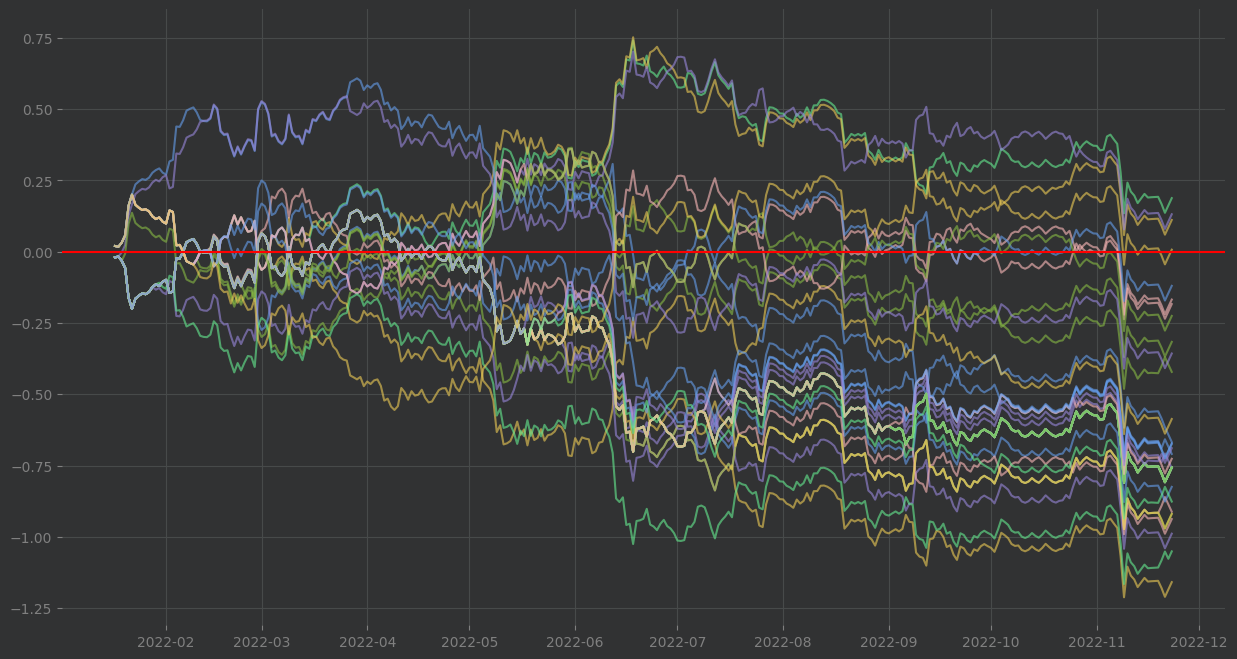

In [42]:
RNN_returns = pd.DataFrame(returns_test, index=[f"RNN n°{i}" for i in range(len(returns_test))]).transpose()

plt.figure(figsize=(15,8))

plt.plot(RNN_returns.cumsum(axis=0), alpha=0.6)

plt.axhline(0, color="red")

plt.show()

# ایجاد شاخصه

In [43]:
def drawdown_function(serie):
    

    cum = serie.dropna().cumsum() + 1

    running_max = np.maximum.accumulate(cum)

    drawdown = cum/running_max - 1
    return drawdown

In [44]:
# دیتافریم خالی ایجاد می کنیم
values = pd.DataFrame(index=["ret/dd", "ret", "dd"])

# محاسبه بازده و حداکثر افت برای هر شبکه عصبی
for col in RNN_returns.columns:
    

  # محاسبه بازده و حداکثر افت برای یک شبکه عصبی
    ret, dd = RNN_returns[col].cumsum().iloc[-1], -np.min(drawdown_function(RNN_returns[col]))

    values[col] = ret/dd, ret, dd

In [45]:
values.transpose().sort_values(by="ret/dd", ascending=False)

,ret/dd,ret,dd
RNN n°7,0.539427,0.187900,0.348332
RNN n°26,0.358390,0.131335,0.366457
RNN n°9,0.280971,0.111271,0.396024
RNN n°39,0.011329,0.007130,0.629325
RNN n°30,-0.226964,-0.119765,0.527683
RNN n°29,-0.418583,-0.183707,0.438878
RNN n°17,-0.426436,-0.167873,0.393665
RNN n°34,-0.479859,-0.225265,0.469440
RNN n°32,-0.577478,-0.357062,0.618312
RNN n°4,-0.588054,-0.316357,0.537973


In [46]:
RNN_models = list(values.transpose().sort_values(by="ret/dd", ascending=False).index[0:3])

In [47]:
RNN_models

['RNN n°7', 'RNN n°26', 'RNN n°9']

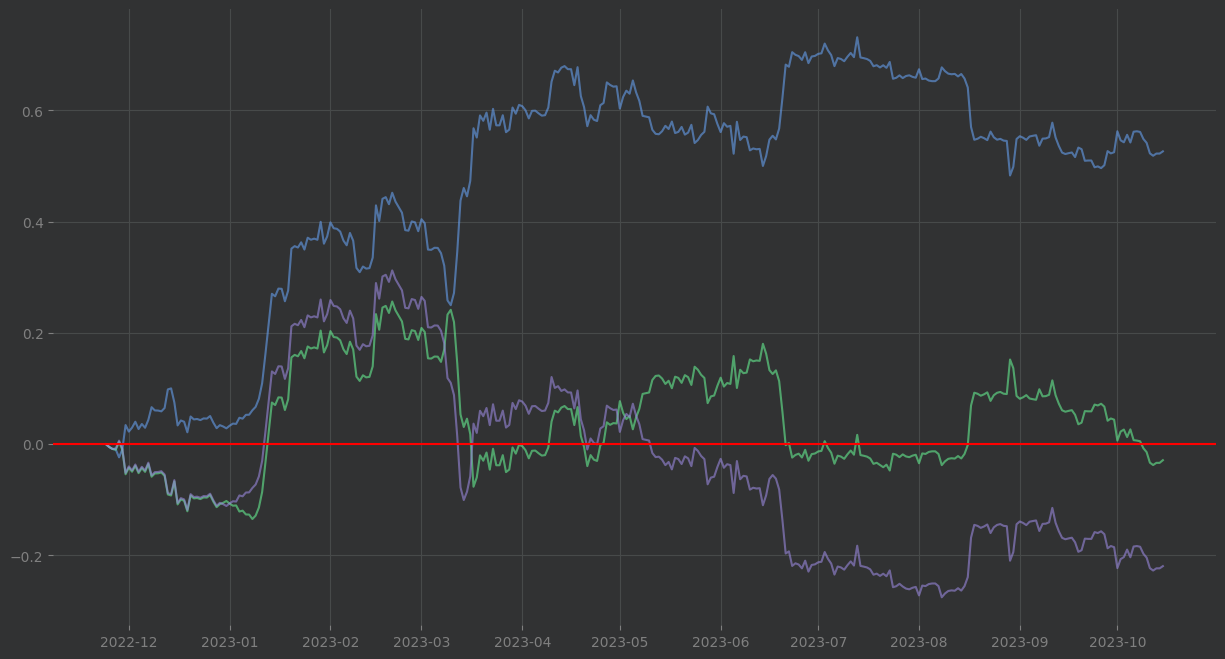

In [48]:
""" از 3 مدل برتر در مجموعه تست برای معامله در مجموعه اعتبار سنجی استفاده می کنیم"""

# سازماندهی داده ها
RNN_val = pd.DataFrame(returns_val, index=[f"RNN n°{i}" for i in range(len(returns_val))]).transpose()

plt.figure(figsize=(15,8))

plt.plot(RNN_val[RNN_models].cumsum(axis=0), alpha=0.6)

plt.axhline(0, color="red")

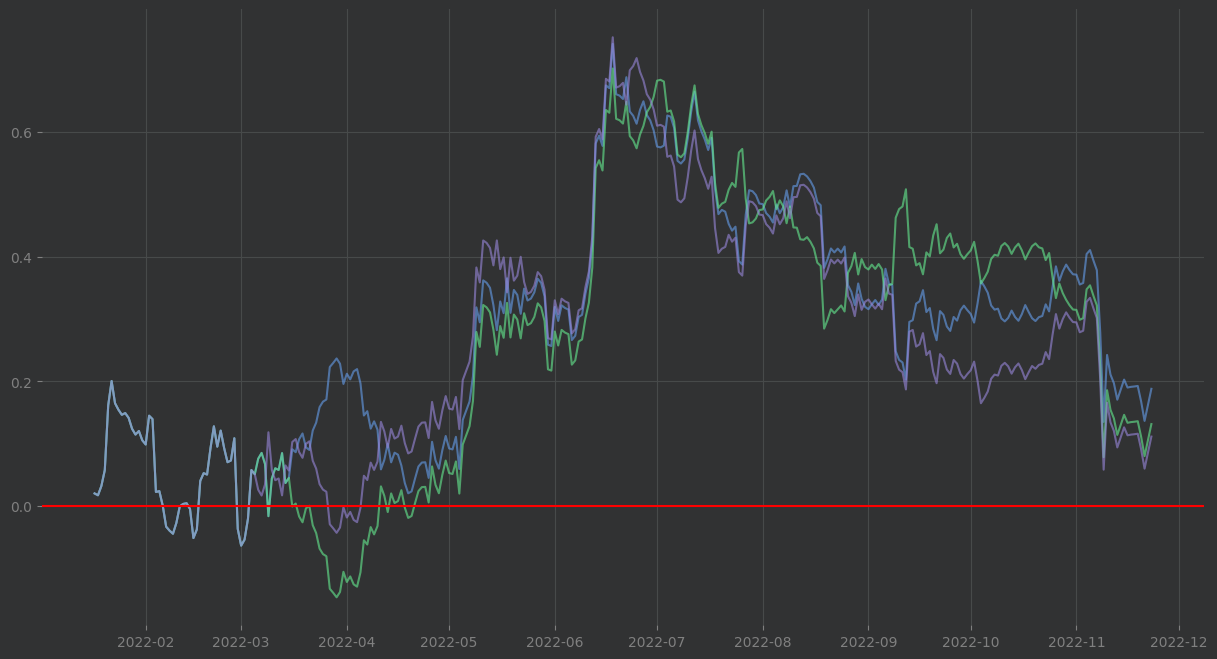

In [49]:
""" از 3 مدل برتر در مجموعه تست برای معامله در مجموعه تست استفاده می کنیم"""

RNN_val = pd.DataFrame(returns_val, index=[f"RNN n°{i}" for i in range(len(returns_val))]).transpose()

plt.figure(figsize=(15,8))

plt.plot(RNN_returns[RNN_models].cumsum(axis=0), alpha=0.6)

plt.axhline(0, color="red")

# Bagging method

In [50]:
def RNN_weights():
    

    classifier = Sequential()

    classifier.add(LSTM(units = 10, return_sequences = True,
                      input_shape = (X_train_3d.shape[1],X_train_3d.shape[2],)))


    for _ in range(1):
        
        classifier.add(LSTM(units = 10, return_sequences = True))
        classifier.add(Dropout(0.50))

    classifier.add(LSTM(units = 10, return_sequences = False))


    classifier.add(Dense(1, activation="sigmoid"))

    classifier.compile(loss="binary_crossentropy", optimizer="adam")

    return classifier

In [51]:
prediction = pd.DataFrame(index = dfc.index)
for nb in RNN_models:
    

    rnn = RNN_weights()

  # وزن های تمرین شده را وارد می کنیم
    rnn.load_weights(f"Weights_RNN/{nb}")

  # ایجاد پیش بینی برای کل مجموعه داده
  
    y_pred_train = np.concatenate((np.zeros([lag,1]),rnn.predict(X_train_3d)),
                                    axis=0)

    y_pred_test = np.concatenate((np.zeros([lag,1]),rnn.predict(X_test_3d)),
                                    axis=0)


    pre = np.concatenate((y_pred_train,y_pred_test),
                                    axis=0)

    prediction[f"{nb}"] = pre
prediction

15/15 [==============================] - 0s 2ms/step


,RNN n°7,RNN n°26,RNN n°9
time,,,
2014-11-16,0.000000,0.000000,0.000000
2014-11-17,0.000000,0.000000,0.000000
2014-11-18,0.000000,0.000000,0.000000
2014-11-19,0.000000,0.000000,0.000000
2014-11-20,0.000000,0.000000,0.000000
...,...,...,...
2023-10-11,0.550277,0.505749,0.521339
2023-10-12,0.550743,0.506086,0.522165
2023-10-13,0.550883,0.506046,0.522434


In [52]:
prediction["Increase"] = (np.sign(prediction[RNN_models]-0.5)==1).sum(axis=1)
prediction["Decrease"] = (np.sign(prediction[RNN_models]-0.5)==-1).sum(axis=1)

In [53]:
# سطرهایی که فقط حاوی 0 هستند را حذف می کنیم
prediction = prediction.iloc[lag:,:]
prediction

,RNN n°7,RNN n°26,RNN n°9,Increase,Decrease
time,,,,,
2014-12-06,0.531289,0.579572,0.534577,3,0
2014-12-07,0.531746,0.580250,0.532096,3,0
2014-12-08,0.532028,0.580063,0.529579,3,0
2014-12-09,0.532256,0.579766,0.527214,3,0
2014-12-10,0.532416,0.580208,0.524892,3,0
...,...,...,...,...,...
2023-10-11,0.550277,0.505749,0.521339,3,0
2023-10-12,0.550743,0.506086,0.522165,3,0
2023-10-13,0.550883,0.506046,0.522434,3,0


In [55]:
prediction["Increase"].value_counts()

Increase
3    2245
2     491
0     272
1     228
Name: count, dtype: int64

<Axes: xlabel='time'>

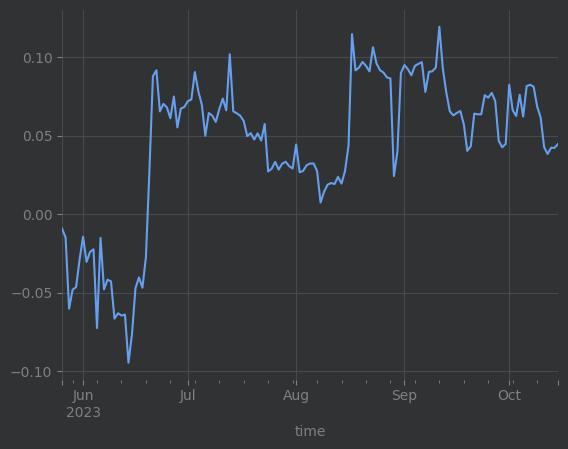

In [56]:
# افزودن بازده روزانه دارایی
prediction["returns"] = dfc["returns"]

prediction["position"] = np.nan
prediction.loc[prediction["Increase"] > prediction["Decrease"], "position"] = 1
prediction.loc[prediction["Increase"] < prediction["Decrease"], "position"] = -1

prediction["strategy"] = prediction["returns"] * prediction["position"].shift(1)
split, split_val = int(0.85*len(dfc)), int(0.95*len(dfc))
prediction["strategy"].iloc[split_val:].cumsum().plot()